In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import date
import matplotlib.pyplot as plt 
from sklearn import preprocessing
pd.set_option('display.max_columns', None)
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error

###### Add new time related features and delete useless ones

In [ ]:
data = pd.read_csv('data_v3_addtext.csv')
data.created = data.created.map(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
data['created_iso_yr'] = data.created.map(lambda x: x.date().isocalendar()[0])
data['created_mo'] = data.created.map(lambda x: x.date().month)
data['created_mo_day'] = data.created.map(lambda x: x.date().day)
data['created_iso_wk'] = data.created.map(lambda x: x.date().isocalendar()[1])
data['date'] = data.created.map(lambda x: x.date())

In [ ]:
useless_cols = ['aid', 'author', 'bvid', 'created', 
                'follower', 'likes', 'play',
                'description', 'title', 'typeid',
                'top1','top2','top3',
                'top1_count', 'top2_count', 'top3_count','count_sum',
                "comment", "video_review"
               ]
data = data.drop(useless_cols, axis = 1)

###### Parameters setting

In [ ]:
cut_off_date = date(2020,8,15)

###### Split Train + Cross Valid, VS Test

In [ ]:
test_idx = data.date > cut_off_date
print('testing percentage:{:.3f}'.format((test_idx).sum() / len(data.date)))
data.drop('date', axis = 1, inplace = True)

testing percentage:0.177


###### Normalization

In [ ]:
file_clean = pd.DataFrame()
for col in data.columns:
    if(col == "log_play"):
        file_clean[col] = data[col].values
    else:
        file_clean[col] = preprocessing.scale(data[col])

In [ ]:
test_df = file_clean[test_idx == True]
train_df = file_clean[test_idx == False]

x_train = train_df.drop(columns = "log_play")
x_test = test_df.drop(columns = "log_play")
y_train = train_df["log_play"]
y_test = test_df["log_play"]
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((12644, 310), (2728, 310), (12644,), (2728,))

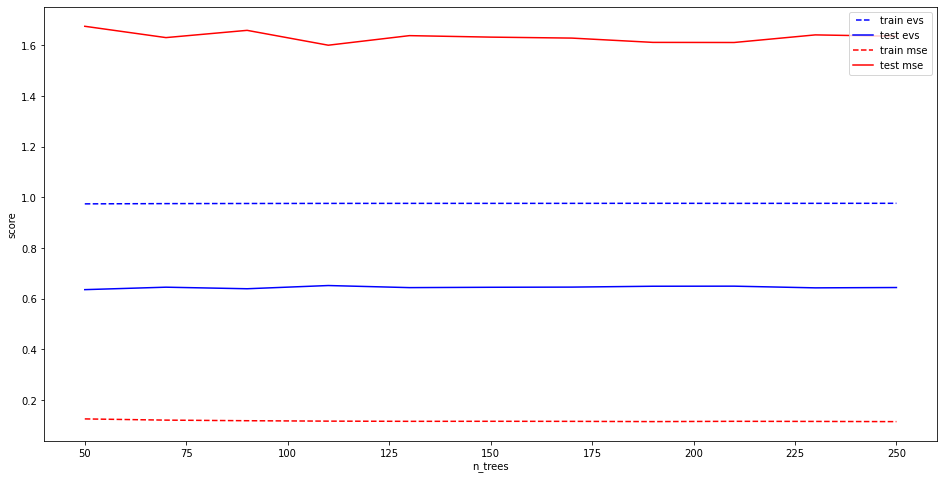

best n_tree is 110 with mse 1.6005612364589827 and R2 0.6519323316927272


In [ ]:
n_trees = np.linspace(50, 250, 11, dtype = int)
train_evs = []
train_mse = []
test_evs = []
test_mse = []
best_n_tree = -1
best_mse = 999
best_evs = 999
for n_tree in n_trees:
   rf1 = RandomForestRegressor(n_estimators=n_tree)
   rf1.fit(x_train, y_train)
   train_pred = rf1.predict(x_train)
   evs_train = explained_variance_score(y_train, train_pred)
   mse_train = mean_squared_error(y_train, train_pred)
   train_evs.append(evs_train)
   train_mse.append(mse_train)
   y_pred = rf1.predict(x_test)
   evs_test = explained_variance_score(y_test, y_pred)
   mse_test = mean_squared_error(y_test, y_pred)
   test_evs.append(evs_test)
   test_mse.append(mse_test)
   if mse_test < best_mse:
       best_mse = mse_test
       best_n_tree = n_tree
       best_evs = evs_test
from matplotlib.legend_handler import HandlerLine2D
plt.figure(figsize=(16,8))
line1, = plt.plot(n_trees, train_evs, '--b', label="train evs")
line2, = plt.plot(n_trees, test_evs, '-b', label="test evs")
line3, = plt.plot(n_trees, train_mse, '--r', label="train mse")
line4, = plt.plot(n_trees, test_mse, '-r', label="test mse")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('score')
plt.xlabel('n_trees')
plt.show()
print("best n_tree is "+str(best_n_tree)+" with mse "+str(best_mse)+" and R2 "+str(best_evs))

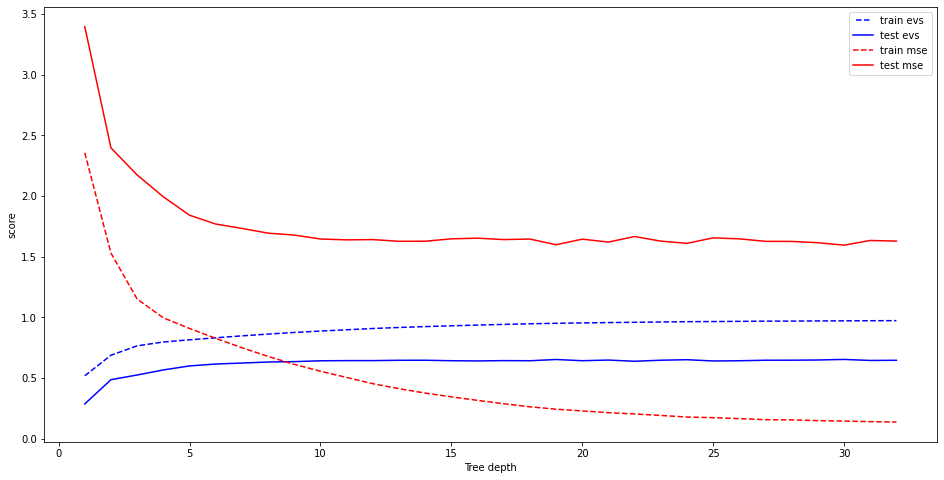

best depth is 30.0 with mse 1.5943117464063714 and R2 0.6525105019199695


In [ ]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_evs = []
train_mse = []
test_evs = []
test_mse = []
best_depth = -1
best_mse = 999
best_evs = 999
for max_depth in max_depths:
   rf2 = RandomForestRegressor(n_estimators=best_n_tree, max_depth=max_depth)
   rf2.fit(x_train, y_train)
   train_pred = rf2.predict(x_train)
   evs_train = explained_variance_score(y_train, train_pred)
   mse_train = mean_squared_error(y_train, train_pred)
   train_evs.append(evs_train)
   train_mse.append(mse_train)
   y_pred = rf2.predict(x_test)
   evs_test = explained_variance_score(y_test, y_pred)
   mse_test = mean_squared_error(y_test, y_pred)
   test_evs.append(evs_test)
   test_mse.append(mse_test)
   if mse_test < best_mse:
       best_mse = mse_test
       best_depth = max_depth
       best_evs = evs_test
from matplotlib.legend_handler import HandlerLine2D
plt.figure(figsize=(16,8))
line1, = plt.plot(max_depths, train_evs, '--b', label="train evs")
line2, = plt.plot(max_depths, test_evs, '-b', label="test evs")
line3, = plt.plot(max_depths, train_mse, '--r', label="train mse")
line4, = plt.plot(max_depths, test_mse, '-r', label="test mse")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('score')
plt.xlabel('Tree depth')
plt.show()
print("best depth is "+str(best_depth)+" with mse "+str(best_mse)+" and R2 "+str(best_evs))

In [ ]:
rf3 = RandomForestRegressor(max_depth=best_depth, n_estimators=best_n_tree)
rf3.fit(x_train, y_train)

y_pred = rf3.predict(x_test)
explained_variance_score(y_test, y_pred)

0.6474643260438414

In [ ]:
file_fi = pd.DataFrame({'importance_value': dt3.feature_importances_}, index=x_train.columns).sort_values(by='importance_value', ascending=False)
file_fi[:20]

,importance_value
last_3month_play,0.803302
length,0.021880
last_3month_count,0.016145
life_ratio,0.010549
food_ratio,0.010204
created_iso_wk,0.007317
created_mo_day,0.006868
hour,0.006338
weekday,0.003233
similiar_title油炸,0.002451


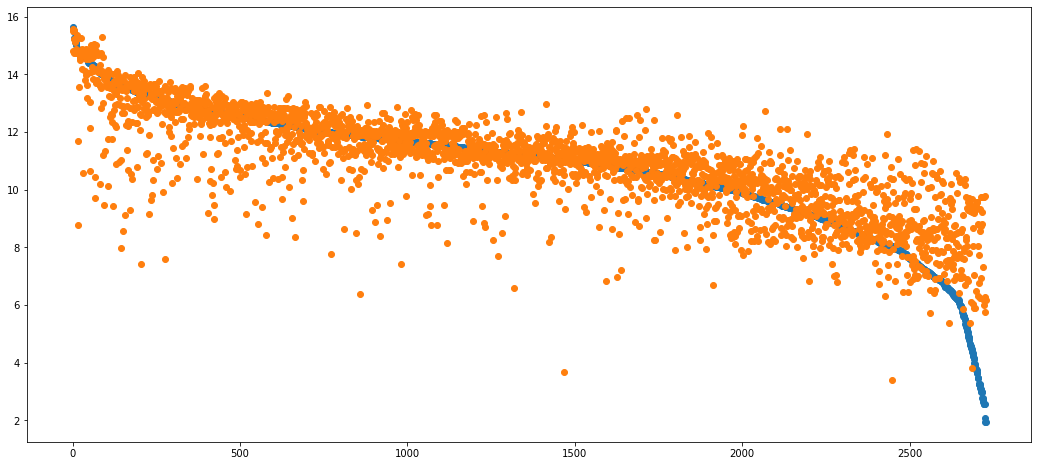

In [ ]:
file_pred = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred}).sort_values(by='y_test', ascending=False)
plt.figure(figsize=(18,8))
plt.scatter(range(file_pred.shape[0]), file_pred.y_test)
plt.scatter(range(file_pred.shape[0]), file_pred.y_pred)